In [1]:
# test the DAM module
from DSS_analyzer_Mariner import Data2D_PFSnapshot
from core import pds
import numpy as np

In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# part of code from MultiSource_tester.ipynb
from datetime import timedelta

# pds frame definition
pds1d_frame = pds.PDS1D_MultiSource()
# setup mesh
nx = 100
dx = 1
x = np.arange(0, nx * dx, dx)

d = 2
u_init = np.zeros(nx)
t0 = 0
lbc = 'Neumann'
rbc = 'Neumann'
# Load test data
from DSS_analyzer_Mariner import Data1D_GAUGE

test_gauge_dataframe = Data1D_GAUGE.Data1D_GAUGE('testdata/pressure_gauge_data.npz')

from DSS_analyzer_Mariner import Data1D_PumpingCurve

stage4_pumping_curve_dataframe = Data1D_PumpingCurve.Data1D_PumpingCurve('testdata/pumping_curve_stage4.npz')
stage5_pumping_curve_dataframe = Data1D_PumpingCurve.Data1D_PumpingCurve('testdata/pumping_curve_stage5.npz')
# Crop the gauge data into three parts
start_time_stg4 = stage4_pumping_curve_dataframe.get_start_time()
end_time_stg4 = stage4_pumping_curve_dataframe.get_end_time()

start_time_stg5 = stage5_pumping_curve_dataframe.get_start_time()
end_time_stg5 = stage5_pumping_curve_dataframe.get_end_time()
stg4_pg_dataframe = test_gauge_dataframe.copy()
stg4_pg_dataframe.crop(start_time_stg4, end_time_stg4)
interval_pg_dataframe = test_gauge_dataframe.copy()
interval_pg_dataframe.crop(end_time_stg4, start_time_stg5)
stg5_pg_dataframe = test_gauge_dataframe.copy()
stg5_pg_dataframe.crop(start_time_stg5, end_time_stg5)
# pass the parameters
pds1d_frame.set_mesh(x)
pds1d_frame.set_diffusivity(d)
pds1d_frame.set_bcs(lbc, rbc)
pds1d_frame.set_t0(t0)
# Set the source index. This time we have 3 sources. This time will not use finner mesh.
from core import mesh_utils

source_idx_1, x_val = mesh_utils.locate(x, 45)
source_idx_2, x_val = mesh_utils.locate(x, 55)
source_idx_3, x_val = mesh_utils.locate(x, 65)
# pass the parameters to pds1d_frame
pds1d_frame.set_sourceidx([source_idx_1, source_idx_2, source_idx_3])
pds1d_frame.sourceidx.shape
# Set sources, I will use the same source for all the sources
total_simulation_time = 1000
# For the test purpose, crop the gauge data
test_gauge_dataframe = stg4_pg_dataframe.copy()
# decide the time range
test_start_time = start_time_stg4 + timedelta(seconds=200)
test_end_time = test_start_time + timedelta(seconds=total_simulation_time)
test_gauge_dataframe.crop(test_start_time, test_end_time)
test_source = [test_gauge_dataframe, test_gauge_dataframe, test_gauge_dataframe]
pds1d_frame.set_source(test_source)
pds1d_frame.print_log()
len(pds1d_frame.source)
u_init[:] = test_gauge_dataframe.data[0]
pds1d_frame.set_initial(u_init)

Diffusivity is a single scalar value, broadcasted to the mesh length.
Mesh is properly set.
Diffusivity is properly set.
Boundary conditions are properly set.
Initial time set done. 
The simulation starts at 0.
Source index is properly set.
Source term is properly set.


In [7]:
pds1d_frame.solve(optimizer= False, dt = 5, t_total= total_simulation_time, print_progress=False)

Time array generated using t_total.
Problem solved.


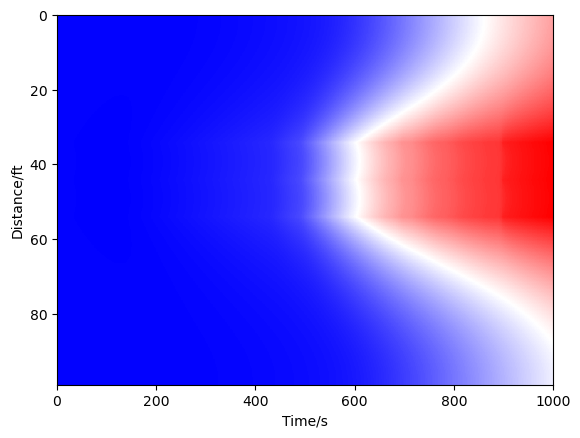

In [8]:
pds1d_frame.plot_solution(method='imshow')

In [12]:
pf_dataframe = Data2D_PFSnapshot.Data2D_PFSnapshot()
pf_dataframe.load_snapshot(data=pds1d_frame.snapshot, taxis=pds1d_frame.taxis, daxis=pds1d_frame.mesh)